# SVM for sleep staging classification
We train a SVM model to automatically classify sleep staging for the two datasets.

### Preprocessing
It is required to perform the preprocessing before training the SVM model:
* Use forward-filling to fill any missing data for the features
* Standardise the features to zero mean and unit variance which will improve the performance of SVM

We use [ffill](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ffill.html) and [bfill](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.bfill.html) from pandas to perform filling. 

We use [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from scikit-learn to perform feature standardization. We need to apply the same transformation later on the test set. We utilise the [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) tool provided by scikit-learn to build up the pipeline of feature standardisation and SVM model.

### Evaluation
We use 10-fold cross-validation for evalation of classifer's performance. Because of the imbalanced datasets, it is important to maintain the proportion of the class distribution for each fold. Scikit-learn provides a nice function called [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) to implement this.
 

We use the performance metrics such as accuracy, precision, recall and F1-score


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, log_loss, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss
# from sklearn.grid_search import GridSearchCV
from sklearn import model_selection
# from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.datasets import load_iris
import generic_func
import importlib

%matplotlib inline
matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', 20)
matplotlib.rcParams['figure.figsize'] = (8, 6)

/home/qfen8290/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# SVM classifier for subjects with Actigraphy data - dataset 1

## Build a SVM classifier pipeline with standard scaler

In [10]:
pp_list = []
scaler = StandardScaler()
pp_list.append(('scaler', scaler))
svc = SVC(cache_size=2000, class_weight='balanced')
pp_list.append(('svc', svc))
pipeline = Pipeline(pp_list)

## Load data

In [3]:
# df = pd.read_csv("./Input//svm_data_clean_160926.csv")
df = pd.read_csv("./Input/ins_subjects_161014.csv", index_col=0, parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19369 entries, 2015-09-09 20:47:01 to 2015-10-01 07:01:16
Data columns (total 21 columns):
Abdomen        19346 non-null float64
Activity       19365 non-null float64
Calf           18541 non-null float64
Chest          19361 non-null float64
Fingertip      19348 non-null float64
Foot           19336 non-null float64
Forearm        19356 non-null float64
Forehead       19361 non-null float64
HR_mean        17791 non-null float64
HR_stdev       17773 non-null float64
Hand           18303 non-null float64
Patient_id     19369 non-null object
ST_DPG         19352 non-null float64
ST_Distal      19352 non-null float64
ST_Proximal    19361 non-null float64
Scapula        19354 non-null float64
Staging        19369 non-null object
Toe            17933 non-null float64
Upperarm       19361 non-null float64
Upperleg       19342 non-null float64
White Light    19365 non-null float64
dtypes: float64(19), object(2)
memory usage: 3.3+ MB


In [5]:
df.head(3)

,Abdomen,Activity,Calf,Chest,Fingertip,Foot,Forearm,Forehead,HR_mean,HR_stdev,...,Patient_id,Scapula,Staging,Toe,Upperarm,Upperleg,White Light,ST_Distal,ST_Proximal,ST_DPG
2015-09-09 20:47:01,33.8525,6.0,32.54225,32.87400,31.93225,34.49425,32.4790,34.5505,0.763625,0.083970,...,INS_WI_004,33.2430,SLEEP-S0,32.1250,32.4985,31.46000,5.30,32.757625,32.671250,-0.086375
2015-09-09 20:47:31,33.8525,27.0,32.54225,32.87400,31.93225,34.49425,32.4790,34.5505,0.757949,0.077656,...,INS_WI_004,33.2430,SLEEP-S0,32.1250,32.4985,31.46000,0.72,32.757625,32.671250,-0.086375
2015-09-09 20:48:01,33.9460,23.0,32.76025,32.96725,32.49375,34.72850,32.5415,34.5820,0.722714,0.068939,...,INS_WI_004,33.2745,SLEEP-S0,32.8265,32.5455,31.52275,0.59,33.147563,32.745375,-0.402188


### Convert `Staging` to `wake (0)` and `sleep (1)` 

In [4]:
df['Staging'] = df['Staging'].apply(lambda s: 0 if 'S0' in s else 1)

### Forward-filling of any missing data

In [5]:
df = df.ffill()
df = df.bfill()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19369 entries, 2015-09-09 20:47:01 to 2015-10-01 07:01:16
Data columns (total 21 columns):
Abdomen        19369 non-null float64
Activity       19369 non-null float64
Calf           19369 non-null float64
Chest          19369 non-null float64
Fingertip      19369 non-null float64
Foot           19369 non-null float64
Forearm        19369 non-null float64
Forehead       19369 non-null float64
HR_mean        19369 non-null float64
HR_stdev       19369 non-null float64
Hand           19369 non-null float64
Patient_id     19369 non-null object
ST_DPG         19369 non-null float64
ST_Distal      19369 non-null float64
ST_Proximal    19369 non-null float64
Scapula        19369 non-null float64
Staging        19369 non-null int64
Toe            19369 non-null float64
Upperarm       19369 non-null float64
Upperleg       19369 non-null float64
White Light    19369 non-null float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.3+ M

In [6]:
y = df.Staging.values
X = df.copy()
X.drop(['Staging','Patient_id'], axis=1, inplace=True)
X = X.values

In [7]:
print(X.shape, y.shape)

(19369, 19) (19369,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
print(y_train.shape, y_test.shape)

(15495,) (3874,)


## Train a svm classifier with feature scaling - dataset 1

In [11]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=2000, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [12]:
pipeline.score(X_train, y_train)

0.9062278154243304

In [13]:
y_pred = pipeline.predict(X_test)

In [14]:
accuracy_score(y_test, y_pred)

0.8954568921011874

In [15]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.69      0.77      0.73       711
          1       0.95      0.92      0.94      3163

avg / total       0.90      0.90      0.90      3874



In [16]:
print(confusion_matrix(y_test, y_pred))

[[ 548  163]
 [ 242 2921]]


## 10-fold cross validation

### Define a function to perform kfold cross validation

In [42]:
def kfold_cv(clf, df, num_fold=10):
    """
    Perform kfold cross-validation.
    Args:
        clf: classifier
        df: dataframe containing all the required data
        num_fold: kfold
    Return:
        a list of accuracy, precision, recall, f1 score for each cv
    """
    acc_list, pr_weighted_list, rec_weighted_list, f1_weighted_list = [], [], [], []
    TP, FP, TN, FN = [], [], [], []
    
    # remove any entry with unscored and covert to wake-sleep
    if df['Staging'].dtype == 'object':
        df = df[df['Staging'] != 'SLEEP-UNSCORED']
        df['Staging'] = df['Staging'].apply(lambda s: 0 if 'S0' in s else 1)
   
    if not isinstance(clf, xgb.sklearn.XGBClassifier):
        df = df.ffill()
        df = df.bfill()
        df.dropna(inplace=True)
    
    skf = model_selection.StratifiedKFold(num_fold, shuffle=True)        
    X = df.drop(['Patient_id', 'Staging'], axis=1)
    y = df['Staging']
     
    for train_ix, test_ix in skf.split(X, y):
        
        print("length of validation set:", len(test_ix))
#         print(df[df['Patient_id']!=sub_test]['Patient_id'].unique())
        y_test = y.iloc[test_ix]
        X_test = X.iloc[test_ix, :]
        y_train = y.iloc[train_ix]
        X_train = X.iloc[train_ix, :]

        if not isinstance(clf, xgb.sklearn.XGBClassifier):
            X_train = X_train.values 
            X_test = X_test.values
            y_train = y_train.values
            y_test = y_test.values
            
        # train the clf
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        # compute scores
        acc_list.append(accuracy_score(y_test, pred))
        pr_weighted_list.append(precision_score(y_test, pred, average='weighted'))
        rec_weighted_list.append(recall_score(y_test, pred, average='weighted'))
        f1_weighted_list.append(f1_score(y_test, pred, average='weighted'))

        cm = confusion_matrix(y_test, pred)
        TP.append(cm[1, 1])
        FP.append(cm[0, 1])
        TN.append(cm[0, 0])
        FN.append(cm[1, 0])
        
    cv_scores = pd.DataFrame({'Fold':[i for i in range(1, num_fold+1)], 'Accuracy':acc_list, 
                              'Precision_weighted': pr_weighted_list,
                              'Recall_weighted': rec_weighted_list, 'F1_weighted': f1_weighted_list,
                              'TP': TP, 'FP': FP, 'FN': FN, 'TN':TN})
    return cv_scores
            
#     return subjects, acc_list, prf_list1, prf_list2,cm

### Build the SVM classifier with optimal parameters - 10 fold CV

In [69]:
pp_list = []
scaler = StandardScaler()
pp_list.append(('scaler', scaler))
svc = SVC(cache_size=2000, class_weight='balanced', kernel='rbf', C=1, gamma='auto')
pp_list.append(('svc', svc))
svc_clf = Pipeline(pp_list)

In [43]:
# svc_clf = svc_gs.best_estimator_
kfold_scores = kfold_cv(svc_clf, df, num_fold=10)

length of validation set: 1938
length of validation set: 1938
length of validation set: 1938
length of validation set: 1937
length of validation set: 1937
length of validation set: 1937
length of validation set: 1936
length of validation set: 1936
length of validation set: 1936
length of validation set: 1936


In [5]:
# kfold_scores = pd.read_csv("./svc_10fold_cv_scores_20subjects.csv", index_col=0)
kfold_scores

,Accuracy,F1_weighted,FN,FP,Fold,Precision_weighted,Recall_weighted,TN,TP
0,0.909701,0.900979,17,158,1,0.910998,0.909701,211,1552
1,0.911249,0.903826,23,149,2,0.910810,0.911249,220,1546
2,0.908669,0.900169,20,157,3,0.909080,0.908669,212,1549
3,0.909654,0.901561,21,154,4,0.909761,0.909654,215,1547
4,0.903459,0.893259,18,169,5,0.904686,0.903459,200,1550
5,0.909654,0.900276,13,162,6,0.912366,0.909654,207,1555
6,0.909607,0.901321,20,155,7,0.909969,0.909607,213,1548
7,0.913223,0.906082,22,146,8,0.912975,0.913223,222,1546
8,0.907541,0.899065,22,157,9,0.907386,0.907541,211,1546
9,0.911157,0.903846,24,148,10,0.910460,0.911157,220,1544


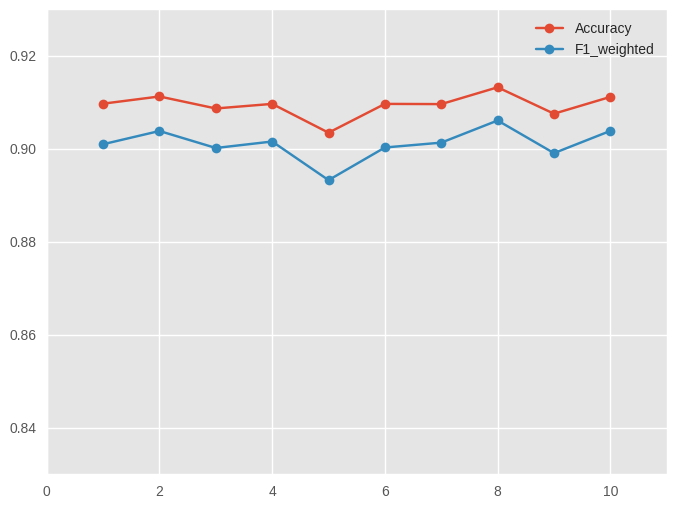

In [6]:
plt.plot(kfold_scores['Fold'], kfold_scores['Accuracy'], '-o')
plt.plot(kfold_scores['Fold'], kfold_scores['F1_weighted'], '-o')
# plt.plot(kfold_scores['Fold'], kfold_scores['Recall_weighted'], '-o')
plt.xlim(0, kfold_scores.shape[0]+1)
plt.ylim(0.83, 0.93)
plt.legend(loc=0)
# kfold_scores.plot.scatter(x=kfold_scores.index, y='Accuarcy')
plt.show()

In [7]:
importlib.reload(generic_func)
avg_acc, avg_pr, avg_re, avg_f1 = generic_func.avg_cv_scores(kfold_scores)
print(avg_acc, avg_f1)

0.909391295369 0.946364719905


# SVM classifier for subjects without Actigraphy data - dataset 2 with 59 subjects

In [47]:
df2 = pd.read_csv("./Input/ins_subjects_no_act_161016.csv", index_col=0, parse_dates=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56174 entries, 2015-09-02 22:49:52 to 2015-10-01 07:01:16
Data columns (total 19 columns):
Abdomen        56142 non-null float64
Calf           54484 non-null float64
Chest          56157 non-null float64
Fingertip      55253 non-null float64
Foot           56132 non-null float64
Forearm        55457 non-null float64
Forehead       55382 non-null float64
HR_mean        53119 non-null float64
HR_stdev       53081 non-null float64
Hand           53307 non-null float64
Patient_id     56174 non-null object
ST_DPG         56148 non-null float64
ST_Distal      56148 non-null float64
ST_Proximal    56157 non-null float64
Scapula        55310 non-null float64
Staging        56174 non-null object
Toe            53836 non-null float64
Upperarm       54214 non-null float64
Upperleg       53331 non-null float64
dtypes: float64(17), object(2)
memory usage: 8.6+ MB


### Convert `Staging` to `wake (0)` and `sleep (1)` 

In [48]:
df2 = df2[df2['Staging']!='SLEEP-UNSCORED']

In [49]:
df2['Staging'] = df2['Staging'].apply(lambda s: 0 if 'S0' in s else 1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55913 entries, 2015-09-02 22:49:52 to 2015-10-01 07:01:16
Data columns (total 19 columns):
Abdomen        55881 non-null float64
Calf           54281 non-null float64
Chest          55896 non-null float64
Fingertip      55165 non-null float64
Foot           55871 non-null float64
Forearm        55196 non-null float64
Forehead       55121 non-null float64
HR_mean        53110 non-null float64
HR_stdev       53072 non-null float64
Hand           53076 non-null float64
Patient_id     55913 non-null object
ST_DPG         55887 non-null float64
ST_Distal      55887 non-null float64
ST_Proximal    55896 non-null float64
Scapula        55049 non-null float64
Staging        55913 non-null int64
Toe            53605 non-null float64
Upperarm       53953 non-null float64
Upperleg       53070 non-null float64
dtypes: float64(17), int64(1), object(1)
memory usage: 8.5+ MB


### Forward-filling 

In [50]:
df2 = df2.ffill()
df2 = df2.bfill()
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55913 entries, 2015-09-02 22:49:52 to 2015-10-01 07:01:16
Data columns (total 19 columns):
Abdomen        55913 non-null float64
Calf           55913 non-null float64
Chest          55913 non-null float64
Fingertip      55913 non-null float64
Foot           55913 non-null float64
Forearm        55913 non-null float64
Forehead       55913 non-null float64
HR_mean        55913 non-null float64
HR_stdev       55913 non-null float64
Hand           55913 non-null float64
Patient_id     55913 non-null object
ST_DPG         55913 non-null float64
ST_Distal      55913 non-null float64
ST_Proximal    55913 non-null float64
Scapula        55913 non-null float64
Staging        55913 non-null int64
Toe            55913 non-null float64
Upperarm       55913 non-null float64
Upperleg       55913 non-null float64
dtypes: float64(17), int64(1), object(1)
memory usage: 8.5+ MB


In [51]:
y = df2.Staging.values
X = df2.copy()
X.drop(['Staging','Patient_id'], axis=1, inplace=True)
X = X.values

In [52]:
print(X.shape, y.shape)

(55913, 17) (55913,)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
print(y_train.shape, y_test.shape)

(44730,) (11183,)


In [54]:
pipeline2 = Pipeline(pp_list)
# pipeline2 = svc_gs.best_estimator_
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=100, cache_size=2000, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [55]:
pipeline2.score(X_train, y_train)

0.91381623071763918

In [56]:
y_pred = pipeline2.predict(X_test)

In [57]:
accuracy_score(y_test, y_pred)

0.89135294643655549

In [58]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.76      0.83      0.80      2851
          1       0.94      0.91      0.93      8332

avg / total       0.90      0.89      0.89     11183



In [59]:
print(confusion_matrix(y_test, y_pred))

[[2373  478]
 [ 737 7595]]


In [119]:
y_pred_prob = pipeline2.predict_proba(X_test)

## 10-fold cross validation

In [44]:
# svc_clf = Pipeline(pp_list)
# svc_clf = svc_gs.best_estimator_
kfold_scores2 = kfold_cv(svc_clf, df2, num_fold=10)

length of validation set: 5619
length of validation set: 5619
length of validation set: 5617
length of validation set: 5617
length of validation set: 5617
length of validation set: 5617
length of validation set: 5617
length of validation set: 5617
length of validation set: 5617
length of validation set: 5617


In [45]:
kfold_scores2
# kfold_scores.to_csv("./svc_10fold_cv_scores_20subjects.csv")

,Accuracy,F1_weighted,FN,FP,Fold,Precision_weighted,Recall_weighted,TN,TP
0,0.849795,0.833921,102,742,1,0.853069,0.849795,710,4065
1,0.853355,0.838989,109,715,2,0.855615,0.853355,737,4058
2,0.852946,0.837320,92,734,3,0.857397,0.852946,717,4074
3,0.850810,0.834956,98,740,4,0.854556,0.850810,711,4068
4,0.853659,0.838039,89,733,5,0.858486,0.853659,718,4077
5,0.854015,0.838433,88,732,6,0.858960,0.854015,719,4078
6,0.849564,0.833821,105,740,7,0.852442,0.849564,711,4061
7,0.858999,0.844982,90,702,8,0.863320,0.858999,749,4076
8,0.856863,0.842569,95,709,9,0.860670,0.856863,742,4071
9,0.850988,0.834770,92,745,10,0.855558,0.850988,706,4074


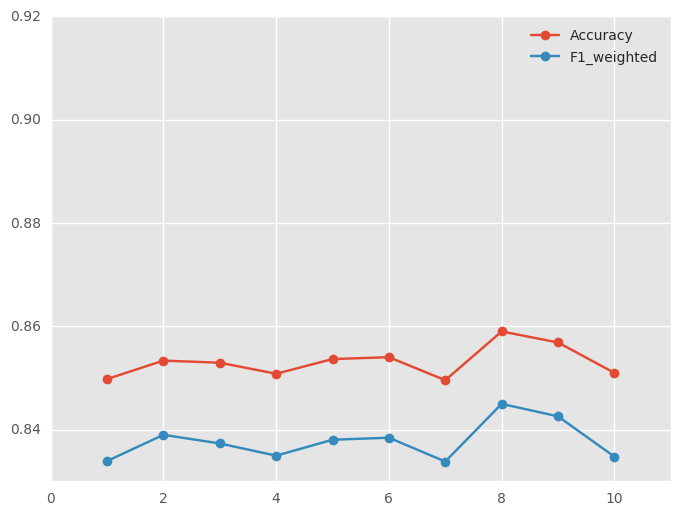

In [135]:
plt.plot(kfold_scores2['Fold'], kfold_scores2['Accuracy'], '-o')
plt.plot(kfold_scores2['Fold'], kfold_scores2['F1_weighted'], '-o')
# plt.plot(kfold_scores['Fold'], kfold_scores['Recall_weighted'], '-o')
plt.xlim(0, kfold_scores2.shape[0]+1)
plt.ylim(0.83,0.92)
plt.legend(loc=0)
# kfold_scores.plot.scatter(x=kfold_scores.index, y='Accuarcy')
plt.show()